In [4]:
#! /usr/bin/env python

"""
Simulation to analyze mating dynamics of cowbirds (or more generally, monogamy in the absence of parental care) 
written by Ammon Perkes (perkes.ammon@gmail.com) at University of Pennsylvania, 2016
""" 

import sys, os
import numpy as np
import copy
from  matplotlib import pyplot as plt
from matplotlib.widgets import Slider
import networkx as nx               # Necessary for all the network analysis and plotting
#from plotly.graph_objs import *    # For playing with nice network graphs, not necessary

#External .py dependencies, contatining Strategies and Stats
import SimStrategies,SimStats

# Default parameters. These can be defined invdividually as well through the parameter class. 

N_MALES = 6
N_FEMALES = 6
RES_M = 1.0       # Resource limitation for a male
RES_F = 1.0       # Resource limitation for a female
RESS_M = [RES_M] * N_MALES     # Resource limitation vector for all males
RESS_F = [RES_F] * N_FEMALES   # Resource limitation vector for all females
Q_MALE = 1.0      # Default Quality for a male
Q_FEMALE = 1.0    # Default Quality for a female
Q_MALES = [Q_MALE] * N_MALES     # Quality vector for maless
Q_FEMALES = [Q_FEMALE] * N_FEMALES # Quality vector for females 
TURNS = 1000       # Number of turns per trial
TRIALS = 10        # Number of trials per simulation
STRAT_M = 4        # Default strategy for males
STRAT_F = 7        # Default strategy for females 
STRATS_M = [STRAT_M] * N_MALES       # Strategy vector for males
STRATS_F = [STRAT_F] * N_FEMALES     # Strategy vector for females
ALPHA = 1.0        # Alpha value scales the adjacency matrix 
ALPHAS = [ALPHA] * N_FEMALES         # Alpha vector for females
BETA = 1.0         # scales the investment -> benefit function
IOTA = 1.5         # scales the investment to adjacency function
KAPPA = 0.0        # defines adjacency kost
OMEGA = 0.5        # maximum cost of crowding
PHI = 1.0          # Fleeing multiplier when determining adjacency
RHO = 0.0          # base risk of individual association
TAU = 2.0          # scales the rate at which crowding cost increases
SHIFT = .1         # amount by which investment is shifted
DECAY = .01         # decay constant 
BUMP = .01         # random encounter rate
MIN_ADJ = .01      # Minimum adjacency
MAX_ADJ = 1.0      # Maximum adjacency

## Functions that define how matrices covert, these are two of the central mechanisms of the simulation
## This could get time consuming, maybe I shouldn't always compute reward...
def adjacency_to_reward2(history, turn, params = None):
    params = history.params

    reward = np.zeros(np.shape(history.reward_matrix[0]))
    n_birds = history.n_males + history.n_females
    current_adjacency = turn.adjacency
    current_investment = turn.invest
    
    for f in range(n_males,n_males + n_females):
            prob_offspring = speed_date(adjacency_vector)
            total_effect, base_effect_vector, marginal_cost_vector = courtship_effect(investment_vector)
            marginal_quality = compare_males(adjacency_vector,history.quality_vector)
        for m in range(n_males):
            reward[m,f] = total_effect * history.quality_vector[f] *  prob_offspring[m] * history.quality_vector[m]
            reward[f,m] = history.quality_vector[m] * prob_offspring[m] * base_effect_vector[m] - marginal_cost_vector[m] - marginal_quality[m]
    return reward

## Given an adjacency vector (and maybe some history) it determines probability of getting offspring
def speed_date(adjacency_vector):
    prob_offspring = adjacency_vector / np.sum(adjacency_vector)
    return prob_offspring

def courtship_effect(investment_vector):
    k = .5 ## Defines the inflection point of search.
    b = 2 ## Defines base search time
    a = 5 ## defines 'tightness' of the sigmoid

    s = lambda x : 1 / (1 + np.e ** (-a * (b - x - k))) ## Functional effect of search time on time alone. This assumes male presence is monotonic, bad
    base_success = s(0)
    total_investment = np.sum(investment_vector)
    total_effect = base_success - s(total_investment) ## The effect of all males being there. 
    base_effect_vector = np.zeros_like(investment_vector)
    marginal_cost_vector = np.zeros_like(investment_vector)
    for m in range(len(investment_vector):
        base_effect_vector[m] = base_success - s(investment_vector[m]) ## The effect of this male just being there (if no one else were there)
        marginal_cost_vector[m] = base_success - s(total_investment - investment_vector[m]) ## The effect of this male stepping out
    return total_effect, base_effect_vector, marginal_cost_vector

def compare_males(adjacency_vector,quality_vector):
    marginal_quality = np.zeros_like(adjacency_vector)
    prob_offspring = speed_data(adjacency_vector)
    offspring_vector = prob_offspring * quality_vector
    expected_quality = offspring_vector.sum()
    for m in range(len(adjacency_vector)):
        temp_prob = np.array(offspring_vector)
        temp_prob[m] = 0
        temp_prob = temp_prob / np.sum(temp_prob)
        temp_offspring = temp_prob * quality_vector
        marginal_quality[m] = expected_quality - temp_offspring.sum()
    return marginal_quality
# just two decisions to make: 
# Who actually got copulations? 
# What's the probability that that copulation produced a successful offspring? 
    
     
def adjacency_to_reward(history, turn, params):
    ## This provides males and females with a reward function on which to base decisions
    # Noteably, this is different from the original implementation, in which the reward *is* the female response
    # Because it needs to update immediately (and really everything should...) it needs the current turn also
    
    alpha = params.alpha # Adjacency benefit multiplier. 
    beta = params.beta # Investment benefit multiplier. 
    omega = params.omega ## This defines the maximum cost of crowding
    tau = params.tau  ## This defines how quickly crowding cost decreases
    kappa = params.kappa ## This defines base adjacency cost
    rho = params.rho ## This defines risk from individual (also a cost)
    n_birds = history.n_males + history.n_females
    r_function = params.r_function
    reward = np.zeros(np.shape(history.reward_matrix[0]))

    #current_adjacency = history.adjacency_matrix[history.current_turn]   # This way it gets the most recent adjacency
    current_adjacency = turn.adjacency # This way it gets the most recent adjacency
    current_investment = turn.invest
    base_adjacency_cost = kappa  #
    individual_cost = rho # This is an invariant risk of associating with any individual ()
    
    # Presumably, costs/benefits should be different for males and females                  
    if r_function == 0:
        for i in range(n_birds):
            for j in range(n_birds):
                crowding_cost = omega / (tau ** (n_birds - current_adjacency[:,j].sum()) + .0001)
                adjacency_cost = current_adjacency[i,j] * base_adjacency_cost + individual_cost
                #adjacency_benefit = (current_adjacency[i,j] / (current_adjacency[:,j].sum() + .0001)) * alpha
                adjacency_benefit = current_adjacency[i,j] ** alpha
                investment_benefit = current_investment[j,i] ** beta
                reward[i,j] = (adjacency_benefit * investment_benefit * history.quality_vector[j]
                                   - crowding_cost - adjacency_cost)
            reward[i,i] = 0
    
    #If desired, set reward for same-sex pairs to 0
    #reward[0:n_males,0:n_males] = 0
    #reward[n_males:,n_males:] = 0
      
    return reward

def investment_to_adjacency2(history, params = None):
## Decision: Should there be explicity historisis with adjacency? 
    current_investment = history.invest_matrix[history.current_turn]
    current_adjacency = current_investment - np.transpose(current_investment)
    return current_adjacency

# Translate investment into adjacency
def investment_to_adjacency(history, params):
    # Here, investment cuts a fraction of the distance, using new investment matrix
    
    iota = params.iota ## This is a parameter that determines how investment scales
    phi = params.phi ## This is a parameter that determines how investment in fleeing scales (get it? phleeing)
    shift_constant = params.shift_constant ## This scales down investment to make everything more gradual
    decay_constant = params.decay_constant
    min_adjacency = params.min_adjacency
    max_adjacency = params.max_adjacency
    previous_adjacency = history.adjacency_matrix[history.current_turn - 1]
    a_function = params.a_function
    ### The following line adds slippage, this is important to avoid crowding when no one is fleeing.
    if a_function == 0:
        encounter_rate = params.bump_constant
        random_encounter = (1 - previous_adjacency) * encounter_rate
        previous_adjacency = previous_adjacency - decay_constant * previous_adjacency 

        previous_investment = history.invest_matrix[history.current_turn - 1]

        shift_matrix = previous_investment ** iota
        shift_matrix[previous_investment < 0] = - (phi + (1 - phi) * previous_investment[previous_investment < 0] ** iota) 
        current_adjacency = previous_adjacency + (previous_adjacency) * shift_matrix * shift_constant + random_encounter
        current_adjacency[current_adjacency < min_adjacency] = min_adjacency
        current_adjacency[current_adjacency > max_adjacency] = max_adjacency
    return current_adjacency

# Parameter object containing all necessary parameters. 
class Parameters(object):
    def __init__(self, r_function = 0, a_function = 0, n_turns = TURNS, n_trials = TRIALS,
                 strat_f = STRAT_F, strat_m = STRAT_M, strats_f = None, strats_m = None, 
                 res_m = RES_M, res_f = RES_F, ress_m = None, ress_f = None,
                 n_males = N_MALES, n_females = N_FEMALES,
                 q_male = Q_MALE, q_female = Q_FEMALE, q_males = None, q_females = None,
                 alpha = ALPHA, alphas = None, beta = BETA, iota = IOTA, kappa = KAPPA, omega = OMEGA, phi = PHI, rho = RHO, tau = TAU,
                 shift_constant = SHIFT, decay_constant = DECAY, bump_constant = BUMP, min_adjacency = MIN_ADJ, max_adjacency = MAX_ADJ):
        self.r_function = r_function
        self.a_function = a_function
        self.alpha = alpha
        self.aphas = alphas
        self.beta = beta
        self.iota = iota
        self.kappa = kappa
        self.omega = omega
        self.phi = phi
        self.rho = rho
        self.tau = tau
        self.shift_constant = shift_constant
        self.decay_constant = decay_constant
        self.bump_constant = bump_constant
        self.min_adjacency = min_adjacency
        self.max_adjacency = max_adjacency
        self.strat_m = strat_m
        self.strat_f = strat_f
        self.strats_m = strats_m
        self.strats_f = strats_f
        self.res_m = res_m    # Resource limitation for a male
        self.res_f = res_f    # Resource limitations for a female (NOTE: This might be unnecessary also....)
        self.ress_m = ress_m
        self.ress_f = ress_f
        self.n_males = n_males    # Number of males per trial 
        self.n_females = n_females # Number of females per trial 
        self.q_male = q_male
        self.q_female = q_female
        self.q_males = q_males
        self.q_females = q_females
        self.n_turns = n_turns # Number of turns per trial
        self.n_trials = n_trials  # Number of trials per simulation
        
        if alphas == None:
            self.alphas = [self.alpha] * self.n_females
        if strats_f == None:
            self.strats_f = [self.strat_f] * self.n_females
        if strats_m == None:
            self.strats_m = [self.strat_m] * self.n_males
        if ress_f == None:
            self.ress_f = [self.res_f] * self.n_females
        if ress_m == None:
            self.ress_m = [self.res_m] * self.n_males
        if self.q_females == None:
            self.q_females = [self.q_female] * self.n_females
        if self.q_males == None:
            self.q_males = [self.q_male] * self.n_males

# Object containing all the birds. Cute, eh? 
# By convention, all matrices are indexed by males then females (so invest[0,n_males] gives you the first males investment in the first female)
class Aviary(object):
    def __init__(self, params = Parameters()):
# Initialize some parameters:
        self.params = params
        self.n_males = params.n_males
        self.n_females = params.n_females
        self.strats_m = params.strats_m
        self.strats_f = params.strats_f
        self.ress_m = params.ress_m
        self.ress_f = params.ress_f
        self.q_males = params.q_males
        self.q_females = params.q_females
# Build the male and female lists in the aviary. 
        self.males = [Male_bird(num, params.strats_m[num], params.ress_m[num], params.q_males[num]) 
                      for num in range(params.n_males)]
        self.females = [Female_bird(num, params.strats_f[num], params.ress_f[num], params.alphas[num], params.q_females[num]) 
                        for num in range(params.n_females)]

        ## This is a big important function. It is how the aviary of birds responds every turn
    def respond(self,history):
        # Initialize Turn
        turn = Turn(history.current_turn,history.n_males,history.n_females)
            
        # Save matrices to the turn
        #turn.invest = self.mrespond(history)
        ## mrespond & frespond also 
        #turn.reward = self.frespond(history)
        turn.adjacency = self.update_adjacency(history, turn)
        turn.invest = self.update_invest(history, turn)
        turn.reward = self.update_reward(history, turn)
        return turn

    def mrespond(self,history):
        
        for m in range(self.n_males):
            history.invest_matrix[history.current_turn] = self.males[m].respond(history)
        return invest

    def frespond(self,history):       
        for f in range(self.n_females):
            history.invest_matrix[history.current_turn] = self.females[f].respond(history)   
        return history.invest_matrix[history.current_turn]
    
    def update_adjacency(self,history,turn):
        
        current_adjacency = investment_to_adjacency(history, self.params)
        return current_adjacency
    
    def update_invest(self,history,turn):
        ## This provides both males and females an opportunity to return investment and competition
        ## For it to work, I need to make sure everything works cleanly
        previous_invest = history.invest_matrix[turn.n - 1]
        male_invest = np.zeros(np.shape(previous_invest))
        female_invest = np.zeros(np.shape(previous_invest))
        history.invest_matrix[turn.n] = previous_invest 
        for m in range(history.n_males):
            history.invest_matrix[turn.n] = self.males[m].respond(history)
        for f in range(history.n_females):
            history.invest_matrix[turn.n] = self.females[f].respond(history)
        #new_invest = male_invest + female_invest
        return history.invest_matrix[turn.n]
    
    def update_reward(self,history,turn):
        new_reward = adjacency_to_reward(history,turn, self.params)
        return new_reward
        
        
class Male_bird(object):
    def __init__(self, num, strategy = 0, resources = 1, quality = 1.0): #Convention: Males have even strategies, females odd. 
        self.num = num
        self.strategy = strategy
        self.resources = resources
        self.quality = quality

##      Seed self investment, and normalize for resources
#   Functions to adjust and get info. 
### NOTE: This is where males apply strategy, strategies are saved externally

    def respond(self,history):
        new_investment = SimStrategies.choose('M0', self.resources, history, self.num)
        return new_investment

#Class of female cowbirds: 
#Includes: resources, response matrix, reward matrix
#Also includes choice function determining response
class Female_bird(object):
    def __init__(self, num, strategy = 1, resources = 1, alpha = ALPHA, quality = 1.0):
        self.num = num
        self.strategy = strategy
        self.resources = resources
        self.alpha = alpha
        self.quality = quality
        self.refraction_time = 5
        self.refraction = False

    #   Functions to adjust and get info. 

    def respond(self,history):
        new_investment = SimStrategies.choose('F0', self.resources, history, self.num)
        return new_investment

#Array type object containing cowbirds, allowing cleverness: 
#Keep history of investment, reward for both males and females

#NOTE: I want to change this so that we have a full matrix of investment, where birds can invest in themselves, in same-sex birds, with negative investment, etc. This is a trivial change as it relates to history, but it will end up being quite a lot of changes down the line. 
class History(object):
    def __init__(self, params = Parameters()):
## Initialize the matrix for the whole sim (save a bunch of time)
        n_males = params.n_males
        n_females = params.n_females
        n_turns = params.n_turns
        self.adjacency_matrix = np.zeros([n_turns,n_males + n_females, n_males + n_females])
        self.adjacency_matrix[0,:n_males,n_males:] = np.random.rand(n_males,n_females)
        self.invest_matrix = np.zeros(np.shape(self.adjacency_matrix))
        self.reward_matrix = np.zeros(np.shape(self.adjacency_matrix))       
        self.n_turns = params.n_turns
        self.n_males = params.n_males
        self.n_females = params.n_females
        self.current_turn = 0
        self.quality_males = params.q_males
        self.quality_females = params.q_females
        self.quality_vector = np.append(params.q_males,params.q_females)
        self.params = params

    def record(self,turn): 
        #self.current_turn = turn.n
        #self.invest_matrix[turn.n] = turn.invest
        #self.reward_matrix[turn.n] = turn.reward
        self.adjacency_matrix[turn.n] = turn.adjacency
        self.invest_matrix[turn.n] = turn.invest
        self.reward_matrix[turn.n] = turn.reward
        self.advance()
        
    def initialize(self,initial_conditions = None): #set first investment conditions
        
        if initial_conditions == None:
            self.invest_matrix[0] = np.random.random([self.n_males + self.n_females, self.n_males + self.n_females]) * (1 - np.identity(self.n_males + self.n_females))
            self.invest_matrix[0] = self.invest_matrix[0] / self.invest_matrix[0].sum(1)
            self.adjacency_matrix[0] = np.random.random(np.shape(self.invest_matrix[0])) * (1 - np.identity(self.n_males + self.n_females))
            self.reward_matrix[0] = self.update_reward_hist()
        else:
            self.invest_matirx[0] = initial_conditions.invest
            self.reward_matrix[0] = initial_conditions.reward
            self.adjacency_matrix[0] = initial_conditions.adjacency
        self.reward_matrix[-1] = self.reward_matrix[0] # This is for when the f_respond checks for previous
        self.invest_matrix[-1] = self.invest_matrix[0]
        self.adjacency_matrix[-1] = self.adjacency_matrix[0]       
        
    def advance(self):
        self.current_turn = self.current_turn + 1
    
    def update_reward_hist(self):
        ## This provides males and females with a reward function on which to base decisions
        # Noteably, this is different from the original implementation, in which the reward *is* the female response
        # Because it needs to update immediately (and really everything should...) it needs the current turn also
        alpha = ALPHA # This should be a different parameter. Not everything is alpha
        
        new_reward = np.empty_like(self.reward_matrix[0])
        #current_adjacency = history.adjacency_matrix[history.current_turn]
        current_adjacency = self.adjacency_matrix[self.current_turn]   # This way it gets the most recent adjacency
        n_birds = self.n_females + self.n_males
        omega = 0.5 ## This defines the maximum cost of crowding
        tau = 2.0  ## This defines how quickly crowding changes
        base_adjacency_cost = 0.0
        individual_risk = 0.0
        for i in range(n_birds):
            for j in range(n_birds):
                crowding_cost = omega / tau ** (1 - current_adjacency[:,j].sum())
                adjacency_cost = current_adjacency[i,j] * base_adjacency_cost
                new_reward[i,j] = (current_adjacency[i,j] ** alpha * self.quality_vector[j] 
                                   - crowding_cost - base_adjacency_cost - individual_risk)
            new_reward[i,i] = 0
        return new_reward         

class Conditions(object):
    def __init__(self, history, t):
        self.invest = history.invest_matrix[t]
        self.reward = history.reward_matrix[t]
        self.adjacency = history.adjacency_matrix[t]
        
#Object containing turn
class Turn(object):
    def __init__(self, n, n_males, n_females, previous_turn = None):
## Initialize based on last turn if desired, otherwise start blank
        self.n = n
        if previous_turn != None:
            self.adjacency = previous_turn.adjacency
            self.invest = previous_turn.invest
            self.reward = previous_turn.reward
        else:
            self.adjacency = np.zeros([n_males+n_females,n_females+n_males])
            self.invest = np.zeros(np.shape(self.adjacency))
            self.reward = np.zeros(np.shape(self.adjacency))
    def change_invest(self,male,female,amount):
        self.invest[male,female] += amount
    def change_reward(self,male,female,amount):
        self.reward[male,female] += amount
    def set_invest(self,male,female,amount):
        self.invest[male,female] = amount
    def set_reward(self,male,female,amount):
        self.reward[male,female] = amount


#Functions determining success: 
#This is not technically important for the simulation, but it determines which strategy is best, which is important

def female_success(params):

    return success

def male_success(params):

    return success

def run_trial(params = Parameters(), initial_conditions = None):
    n_males = params.n_males
    n_females = params.n_females
    n_turns = params.n_turns
## Initialize full record...
## initialize history
    history = History(params)
    history.initialize(initial_conditions)
# Build an aviary using the given parameters
    aviary = Aviary(params)
# Initialize initial investment (based on male resources, if specified)
    history.initialize()
# Get first female response:
    #history.reward_matrix[0] = aviary.frespond(history)
    history.advance()
# For every turn, calculate response and record it in history.
    for t in range(n_turns-1):
        turn = aviary.respond(history)
        history.record(turn)
    return history
       
def run_simulation(params = Parameters()):

    record = [0 for tr in range(params.n_trials)]
    for tr in range(params.n_trials):
        history = run_trial(params)
        record[tr] = SimStats.get_stats(history) 
# For tidiness, stats is saved in a seperate file
    return record

def evolving_simulation(params = Parameters()):
    record = [0 for tr in range(params.n_trials)]
    p_record = [0 for p in range(params.n_trials)]
    for tr in range(params.n_trails):
        history = run_trial(params)
        trial_stats = SimStats.get_stats(history)
        record[tr] = trial_stats
        p_record[tr] = params
        params = update_strategy(params,trial_stats)
    return record, p_record
        
def update_strategy(params,trial_stats):
    old_strats_m = params.strats_m
    old_strats_f = params.strats_f
    new_params = copy.copy(params)
    for k in trial_stats['fitness_m'].keys():
        num = trial_stats['fitness_m'][k]
        for n in range(num):
            new_strats_m.append(k)
    for k in trial_stats['fitness_f'].keys():
        num = trial_stats['fitness_f'][k]
        for n in range(num):
            new_strats_f.append(k)
    new_params.strats_m = new_strats_m
    new_params.strats_f = new_strats_f
    return new_params
            
    
#### Plotting Functions ####
    
def plot_history(invest_matrix):
    # generate a five layer data 
    data = invest_matrix
    # current layer index start with the first layer 
    idx = 0

    # figure axis setup 
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.15)

    # display initial image 
    im_h = ax.imshow(data[idx, :, :], vmin=-1.0, vmax=1., cmap='bwr', interpolation='nearest')

    # setup a slider axis and the Slider
    ax_depth = plt.axes([0.23, 0.02, 0.56, 0.04])
    slider_depth = Slider(ax_depth, 'depth', 0, data.shape[0]-1, valinit=idx)

    # update the figure with a change on the slider 
    def update_depth(val):
        idx = int(round(slider_depth.val))
        im_h.set_data(data[idx, :, :])

    slider_depth.on_changed(update_depth)

    plt.show()
    
### Several Functions for Network Plotting ###

def plot_network_progression(history):
    turns = history.current_turn
    seed_turn = 0
    adj_rounded = np.round(history.adjacency_matrix[seed_turn] + .4) * 4
    G = nx.from_numpy_matrix(adj_rounded)
    #G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

    pos = nx.spring_layout(G)
    #pos = nx.spectral_layout(G)
    #pos = nx.circular_layout(G)
    #pos = nx.shell_layout(G)
    #pos = nx.kamada_kawai_layout(G)
    
    #turns = 160
    step = turns / 20
    wait_time = .5
    for t in range(0,turns,step):
        plt.cla()
        adj_rounded = history.adjacency_matrix[t]
        adj_rounded[adj_rounded < .1] = 0.0
        adj_rounded.dtype = [('weight','float')]
        G = nx.from_numpy_matrix(adj_rounded,parallel_edges=False)
        pos = nx.spring_layout(G, pos=pos, fixed=None)
        color_map = []
        for node in G:
            if int(node) < history.n_males:
                color_map.append('blue')
            else: color_map.append('red')    
        edges = G.edges()
        weights = [G[u][v]['weight'] for u,v in edges]
        nx.draw(G, pos, node_color = color_map, with_labels = True, edges=edges, width=weights, node_size=450)
        plt.pause(wait_time)
        plt.draw()
    
def plot_network(adjacency):
    plt.cla()
    G = nx.from_numpy_matrix(adjacency,parallel_edges=False)
    # Set layount: 
    pos = nx.spring_layout(G)
    color_map = []
    n_males, n_females = np.shape(investment)
    for node in G:
        if int(node) < n_males:
            color_map.append('blue')
        else: color_map.append('red')    

    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    nx.draw(G, pos, node_color = color_map, with_labels = True, edges=edges, width=weights)

    plt.show()
        

if __name__ == "__main__":
    
    #history = run_trial()
    #run_simulation(alphas = [1.5]*N_FEMALES)
    #plot_history(history)
    #plot_network_progression(history)
    pass


<IPython.core.display.Javascript object>


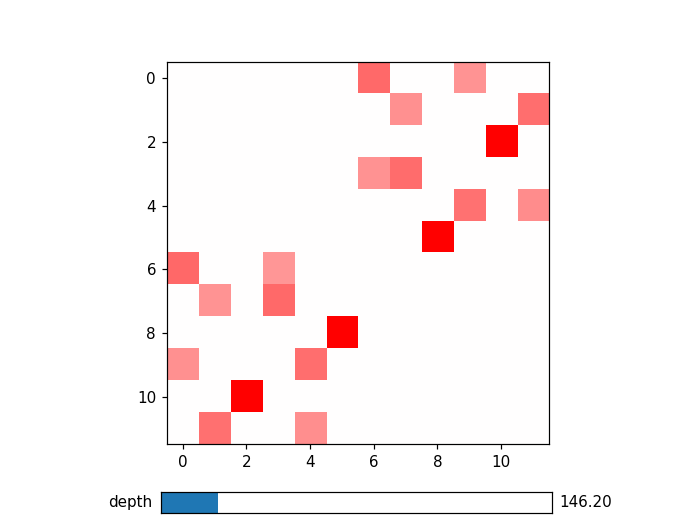

In [8]:
%matplotlib notebook
history = run_trial()
plot_history(history.invest_matrix)

## Things to do: 

-Create new Inv. to Adj. and Adj. to Rew. functions in order to handle new schema
--In this case, Rew is my measure of fitness (why not reward?)
-Debug new construct that runs a trial, checks success, and seeds new trial with different strategies (based on evolution) 
-Do very simple approach
-Do slightly more complex approach
-Talk to Erol/Vijay about parameter exploration


In [15]:
print(history.params.strats_m)

[4, 4, 4, 4, 4, 4]


In [22]:
print(np.sum(history.adjacency_matrix,0))
print(np.sum(np.sum(history.adjacency_matrix,0),1))

[[475.00000004 496.25064629 501.77983396 505.14470123 488.37478577
  486.23776345 988.60316551 480.41789637 508.27969779 986.71014747
  483.70872805 506.5718076 ]
 [510.07962614 475.00000004 510.84518371 496.60102753 494.76625346
  520.96674404 491.24114268 995.74571361 486.84924115 488.86499489
  487.34486513 993.68719846]
 [517.40538866 518.07936006 475.00000004 518.26356201 514.47104141
  521.79194136 488.44759772 483.42819008 554.61693418 500.0471082
  997.48777852 495.86264283]
 [513.18882815 495.50533981 483.39949259 475.00000004 487.10462841
  523.25625982 989.40200832 972.26069442 518.43058316 481.10700594
  537.88225145 480.07631321]
 [478.31203679 480.60857126 514.91624252 488.25438429 475.00000004
  480.27868164 484.10171866 491.95105695 523.07778813 999.49325676
  524.42293141 980.96743308]
 [476.70760562 523.52183782 492.44991206 510.88806564 498.74730831
  475.00000004 482.81366121 518.02087184 962.30872323 533.63550814
  563.16331959 479.11416088]
 [971.02107208 527.8488

In [24]:
print(np.sum(history.adjacency_matrix[:,:,0]))

6934.29595530492


In [26]:
history.

array([[0.        , 0.11980618, 0.18806373, 0.06442853, 0.21556204,
        0.19473343, 0.01532924, 0.06587326, 0.02157896, 0.04733176,
        0.12999401, 0.12116053],
       [0.00502389, 0.        , 0.1884477 , 0.18590606, 0.08642944,
        0.16368139, 0.1260357 , 0.12072932, 0.14558576, 0.08848358,
        0.09301098, 0.00384393],
       [0.01889955, 0.04283795, 0.        , 0.12694394, 0.06807733,
        0.04614577, 0.13219771, 0.05686663, 0.01669748, 0.15868078,
        0.08583666, 0.03684646],
       [0.00796311, 0.1198104 , 0.19968645, 0.        , 0.06945618,
        0.09751692, 0.01886954, 0.11044313, 0.02460078, 0.09966734,
        0.24378327, 0.05920637],
       [0.03580185, 0.06187523, 0.03209696, 0.0045037 , 0.        ,
        0.03716734, 0.06743592, 0.0686131 , 0.01790312, 0.11426963,
        0.09013719, 0.17441411],
       [0.02205263, 0.08742303, 0.07340595, 0.12951045, 0.10142624,
        0.        , 0.03657407, 0.01072947, 0.17216158, 0.05770817,
        0.03501578,

In [1]:
import numpy as np


In [ ]:
np.zeros_like